In [ ]:
#This is where the code starts.

In [1]:
from pytube import YouTube, Channel
import whisper
import os
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
from moviepy.editor import AudioFileClip
from googleapiclient.discovery import build
from datetime import datetime, timedelta
from dotenv import load_dotenv
from transformers import AutoTokenizer 
from transformers import AutoModelForSequenceClassification
from transformers import pipeline  

In [28]:
# This is the function for sentimen analysis and it works!
 

In [2]:
# This is how we get our function called final_df
import pandas as pd
import openai
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Initialize OpenAI API
openai.api_key = 'sk-proj-ggeheV85h9E9BHTgpycNT3BlbkFJIANFULv09YXo8exqduw0'

# Define the models with their corresponding paths
models = {
    "FinancialBERT": "yiyanghkust/finbert-tone",
    "bert-base-uncased": "bert-base-uncased",
    "ProsusAI/finbert": "ProsusAI/finbert"
}

def analyze_sentiment_gpt35turbo(text):
    """
    Analyze sentiment of a given text using GPT-3.5-turbo.

    Parameters:
    - text (str): The input text to analyze.

    Returns:
    - sentiment (str): The sentiment label of the text.
    """
    if not text:
        return "We need text"  
    messages = [
        {"role": "system", "content": "You are a sentiment analysis assistant."},
        {"role": "user", "content": f"Please analyze the sentiment of the following text and classify it as Positive, Negative, or Neutral:\n\n{text}"}
    ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    sentiment = response.choices[0].message['content'].strip()
    return sentiment

def analyze_sentiment_huggingface(text, model_path):
    """
    Analyze sentiment of a given text using a specified pre-trained model from Hugging Face.

    Parameters:
    - text (str): The input text to analyze.
    - model_path (str): The path to the pre-trained model.

    Returns:
    - label (str): The sentiment label of the text.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    
    result = sentiment_analyzer(text)[0]
    return result['label']

def analyze_csv_sentiments(input_csv, output_csv):
    """
    Analyze sentiments of text data in a CSV file using multiple pre-trained models and
    store the results in separate columns for each model.

    Parameters:
    - input_csv (str): Path to the input CSV file containing text data.
    - output_csv (str): Path to save the output CSV file with sentiment analysis results.

    Returns:
    - df (DataFrame): The updated DataFrame with sentiment analysis results.
    """
    
    df = pd.read_csv(input_csv)

    # make sure there is a column to analyze
    if 'text' not in df.columns:
        raise ValueError("The CSV file must contain a 'text' column for analysis.")

    # Analyze sentiment for each row using each model and add results to new columns
    df['gpt-3.5-turbo_sentiment'] = df['text'].apply(analyze_sentiment_gpt35turbo)
    
    for model_name, model_path in models.items():
        df[f'{model_name}_sentiment'] = df['text'].apply(lambda text: analyze_sentiment_huggingface(text, model_path))

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_csv, index=False)
    
    # Return the updated DataFrame
    return df




In [7]:
# This will take a while and this is how we generate our file with the above function
input_csv = "test_file.csv"  # Path to the input CSV file
output_csv = "output_with_sentiments1.csv"  # Path to save the output CSV file with sentiments
result_df = analyze_csv_sentiments(input_csv, output_csv)
print(result_df.head())  # Print the first few rows of the updated DataFrame

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are

   Unnamed: 0                                               text  \
0           0  According to Gran , the company has no plans t...   
1           1  Technopolis plans to develop in stages an area...   
2           2  The international electronic industry company ...   
3           3  With the new production plant the company woul...   
4           4  According to the company 's updated strategy f...   

                             gpt-3.5-turbo_sentiment FinancialBERT_sentiment  \
0                                            Neutral                 Neutral   
1             The sentiment of the text is Positive.                 Neutral   
2  The sentiment of the text is Negative, as it m...                 Neutral   
3             The sentiment of the text is Positive.                Positive   
4                                            Neutral                Positive   

  bert-base-uncased_sentiment ProsusAI/finbert_sentiment  
0                     LABEL_0                    ne

In [3]:
# This is for simplifying the answer of gpt 3.5 turbo 
def find_sentiment_words(input_csv, output_csv, column_name):
    df = pd.read_csv(input_csv)
    
    if column_name not in df.columns:
        raise ValueError(f"The column {column_name} does not in the CSV file.")
        
    sentiment_words = ["Positive","Neutral","Negative"]
    
    df['chatgpt_sentiment'] = None
    
    for index,row in df.iterrows():
        text = row[column_name]
        
        for word in sentiment_words:
            if pd.notnull(text) and word.lower() in text.lower():
                df.at[index, 'chatgpt_sentiment'] = word
                break
    
    df.to_csv(output_csv, index = False)
    
    return df

In [4]:
input_csv = "output_with_sentiments1.csv"
output_csv = "updated_sentiments.csv"
column_name = "gpt-3.5-turbo_sentiment"


In [5]:
# updated version of our file with chat_gpt sentiment
final_df = find_sentiment_words(input_csv,output_csv, column_name)
final_df

,Unnamed: 0,text,gpt-3.5-turbo_sentiment,FinancialBERT_sentiment,bert-base-uncased_sentiment,ProsusAI/finbert_sentiment,chatgpt_sentiment
0,0,"According to Gran , the company has no plans t...",Neutral,Neutral,LABEL_0,neutral,Neutral
1,1,Technopolis plans to develop in stages an area...,The sentiment of the text is Positive.,Neutral,LABEL_1,neutral,Positive
2,2,The international electronic industry company ...,"The sentiment of the text is Negative, as it m...",Neutral,LABEL_0,negative,Negative
3,3,With the new production plant the company woul...,The sentiment of the text is Positive.,Positive,LABEL_1,positive,Positive
4,4,According to the company 's updated strategy f...,Neutral,Positive,LABEL_0,positive,Neutral
...,...,...,...,...,...,...,...
4841,4841,LONDON MarketWatch -- Share prices ended lower...,The sentiment of the text is Negative.,Negative,LABEL_1,negative,Negative
4842,4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,This text contains a mix of positive and negat...,Positive,LABEL_0,negative,Positive
4843,4843,Operating profit fell to EUR 35.4 mn from EUR ...,The sentiment of the text is Neutral.,Negative,LABEL_1,negative,Neutral
4844,4844,Net sales of the Paper segment decreased to EU...,This text contains a factual statement regardi...,Negative,LABEL_1,negative,Neutral


In [6]:
# This is where we want to change the lable to positive (we dropped this column later today)
final_df[final_df['bert-base-uncased_sentiment'] == 'LABEL_1'] = "Positive"

In [8]:
# Again just some processing on the columns like doing upper case. 
replacements = {"LABEL_1":"Positive", 
                "LABEL_0":"Neutral"
              # "LABEL_":"Negative"????
    }
for old_word, new_word in replacements.items(): 
        final_df['bert-base-uncased_sentiment'].replace(old_word, new_word, inplace=True)
        
        #print(final_df)
replacements = {"positive":"Positive", 
                "neutral":"Neutral",
               "negative":"Negative"
    }
for old_word, new_word in replacements.items(): 
        final_df['ProsusAI/finbert_sentiment'].replace(old_word, new_word, inplace=True)
        
        print(final_df)

     Unnamed: 0                                               text  \
0             0  According to Gran , the company has no plans t...   
1      Positive                                           Positive   
2             2  The international electronic industry company ...   
3      Positive                                           Positive   
4             4  According to the company 's updated strategy f...   
...         ...                                                ...   
4841   Positive                                           Positive   
4842       4842  Rinkuskiai 's beer sales fell by 6.5 per cent ...   
4843   Positive                                           Positive   
4844   Positive                                           Positive   
4845   Positive                                           Positive   

                                gpt-3.5-turbo_sentiment  \
0                                               Neutral   
1                                        

In [ ]:
# It ends here and the rest should be what we did when sharing screen

In [9]:
# Load the FinBERT sentiment analysis model
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [11]:
#Create a sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def analyze_sentiment(answer):
    """
    Analyze the sentiment of chunks of the answer and get the overall sentiment.

    Parameters:
    - answer (str): The answer text to analyze.

    Returns:
    - overall_sentiment (str): The overall sentiment of the answer.
    """
    # Split the answer into chunks (e.g., by sentences)
    chunks = answer.split('. ')
    
    # Analyze sentiment for each chunk
    sentiments = []
    for chunk in chunks:
        if chunk.strip():  # Avoid empty strings
            result = sentiment_analyzer(chunk)[0]
            sentiments.append(result['label'])
    
    # Calculate the overall sentiment
    sentiment_counts = pd.Series(sentiments).value_counts()
    overall_sentiment = sentiment_counts.idxmax()  # The sentiment with the highest count

    # Print the sentiment of each chunk
    for i, sentiment in enumerate(sentiments):
        print(f"Chunk {i + 1}: {sentiment}")

    print(f"Overall Sentiment: {overall_sentiment}")
    return overall_sentiment

In [12]:
answer = "The stock price increased significantly. However, there are concerns about future earnings. Overall, the market response was positive."
overall_sentiment = analyze_sentiment(answer)

Chunk 1: positive
Chunk 2: negative
Chunk 3: positive
Overall Sentiment: positive


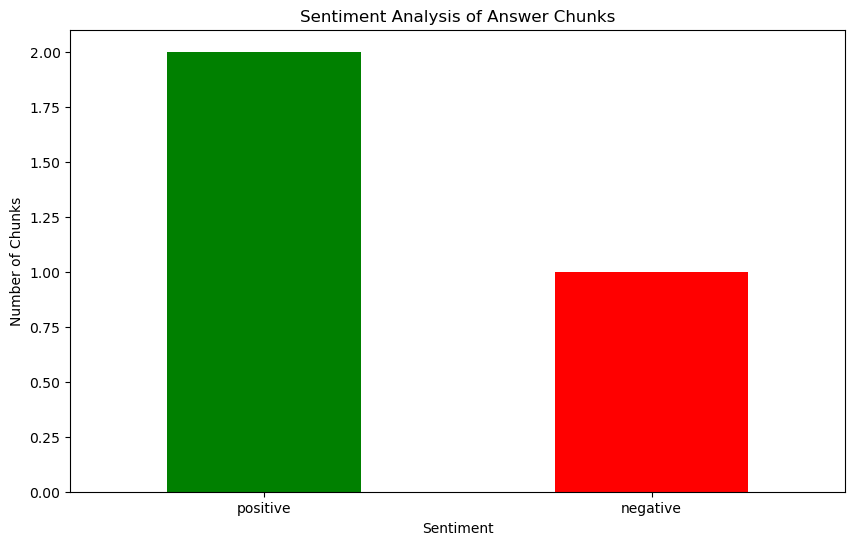

Chunk 1: positive
Chunk 2: negative
Chunk 3: positive


In [21]:
from matplotlib import pyplot as plt
# Load the FinBERT sentiment analysis model
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def analyze_and_plot_sentiment(answer):
    """
    Analyze the sentiment of chunks of the answer, get the overall sentiment,
    and plot the sentiment labels.

    Parameters:
    - answer (str): The answer text to analyze.

    Returns:
    - overall_sentiment (str): The overall sentiment of the answer.
    """
    # Split the answer into chunks (e.g., by sentences)
    chunks = answer.split('. ')
    
    # Analyze sentiment for each chunk
    sentiments = []
    for chunk in chunks:
        if chunk.strip():  # Avoid empty strings
            result = sentiment_analyzer(chunk)[0]
            sentiments.append(result['label'])
    
    # Calculate the overall sentiment
    sentiment_counts = pd.Series(sentiments).value_counts()
    overall_sentiment = sentiment_counts.idxmax()  # The sentiment with the highest count

    # Plot the sentiment labels of each chunk
    plt.figure(figsize=(10, 6))
    sentiment_counts.plot(kind='bar', color=['green' if label == 'positive' else 'red' if label == 'negative' else 'yellow' for label in sentiment_counts.index])
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Chunks')
    plt.title('Sentiment Analysis of Answer Chunks')
    plt.xticks(rotation=0)
    plt.show()

    # Print the sentiment of each chunk and the overall sentiment
    for i, sentiment in enumerate(sentiments):
        print(f"Chunk {i + 1}: {sentiment}")

    # print(f"Overall Sentiment: {overall_sentiment}")
    # return overall_sentiment

# Example usage
answer = "The stock price increased significantly. However, there are concerns about future earnings. Overall, the market response was positive."
overall_sentiment = analyze_and_plot_sentiment(answer)

In [ ]:
#### this one below 

In [ ]:
import pinecone
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize Pinecone
pinecone.init(api_key='pinecone_api_key', environment='pinecone_environment')
index_name = 'finance-questions'
if index_name not in pinecone.list_indexes():
    pinecone.create_index(index_name, dimension=768)  # I chose 768 dimensions for embeddings? not sure if this is the case 
index = pinecone.Index(index_name)

# Load the FinBERT sentiment analysis model
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def analyze_and_plot_sentiment(context):
    """
    Analyze the sentiment of chunks of the context, get the overall sentiment,
    and plot the sentiment labels.

    Parameters:
    - context (str): The context text to analyze.

    Returns:
    - overall_sentiment (str): The overall sentiment of the context.
    """
    # Split the context into chunks using Langchain text splitter
    text_splitter = RecursiveCharacterTextSplitter(max_chunk_size=1000, chunk_overlap=200)   # ? set it to chunksize and overlap 
    chunks = text_splitter.split_text(context)
    
    # Embed and store chunks in Pinecone, and analyze sentiment for each chunk
    sentiments = []
    for chunk in chunks:
        if chunk.strip():  # Avoid empty strings
            # Embed the chunk using OpenAI embeddings
            embeddings = OpenAIEmbeddings().embed_text(chunk)
            
            # Upsert the chunk into Pinecone
            index.upsert([(str(hash(chunk)), embeddings)])   # people had issues with this. I read online 
            
            # Analyze the sentiment
            result = sentiment_analyzer(chunk)[0]
            sentiments.append(result['label'])
    
    # Calculate the overall sentiment
    sentiment_counts = pd.Series(sentiments).value_counts()
    overall_sentiment = sentiment_counts.idxmax()  # The sentiment with the highest count

    # Plot the sentiment labels of each chunk
    plt.figure(figsize=(10, 6))
    sentiment_counts.plot(kind='bar', color=['green' if label == 'positive' else 'red' if label == 'negative' else 'yellow' for label in sentiment_counts.index])
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Chunks')
    plt.title('Sentiment Analysis of Context Chunks')
    plt.xticks(rotation=0)
    plt.show()

    # Print the sentiment of each chunk and the overall sentiment
    for i, sentiment in enumerate(sentiments):
        print(f"Chunk {i + 1}: {sentiment}")

    print(f"Overall Sentiment: {overall_sentiment}")
    return overall_sentiment

# Example usage
context = "The stock price increased significantly. However, there are concerns about future earnings. Overall, the market response was positive."
overall_sentiment = analyze_and_plot_sentiment(context)

In [4]:
# I added "score" to the print at the end, can you try and see if it runs? 

import openai
# Initialize OpenAI API
openai.api_key = 'sk-proj-ggeheV85h9E9BHTgpycNT3BlbkFJIANFULv09YXo8exqduw0'
def analyze_sentiment(text):
    # Define the message to instruct GPT-3.5-turbo to perform sentiment analysis
    messages = [
        {"role": "system", "content": "You are a sentiment analysis assistant."},
        {"role": "user", "content": f"Please analyze the sentiment of the following text and classify it as Positive, Negative, or Neutral:\n\n{text}"}
    ]
    # Call the OpenAI API with the messages
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages
    )
    # Extract the sentiment from the response
    sentiment = response.choices[0].message['content'].strip()
    return sentiment
# Example usage
text = "The company's stock price has seen a significant increase due to strong quarterly earnings."
sentiment = analyze_sentiment(text)
print(f"Text: {text}\nSentiment: {sentiment}\nScore:{score}")

Text: The company's stock price has seen a significant increase due to strong quarterly earnings.
Sentiment: The sentiment of the text is Positive.


In [18]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Define the models with their corresponding paths
models = {
    "FinancialBERT": "yiyanghkust/finbert-tone",
    "bert-base-uncased": "bert-base-uncased",
    "ProsusAI/finbert": "ProsusAI/finbert"
}

def analyze_sentiment(text, model_path):
    """
    Analyze sentiment of a given text using a specified pre-trained model.
    
    Parameters:
    - text (str): The input text to analyze.
    - model_path (str): The path to the pre-trained model.

    Returns:
    - label (str): The sentiment label of the text.
    """
    # Load the tokenizer and model using the specified model path
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    
    # Create a sentiment analysis pipeline
    sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    
    # Perform sentiment analysis on the input text
    result = sentiment_analyzer(text)[0]
    
    # Return the sentiment label
    return result['label']

def analyze_csv_sentiments(input_csv, output_csv):
    """
    Analyze sentiments of text data in a CSV file using multiple pre-trained models and
    store the results in new columns for each model.
    
    Parameters:
    - input_csv (str): Path to the input CSV file containing text data.
    - output_csv (str): Path to save the output CSV file with sentiment analysis results.

    Returns:
    - df (DataFrame): The updated DataFrame with sentiment analysis results.
    """
    # Load the CSV file into a DataFrame
    df = pd.read_csv(input_csv)

    # Ensure there is a column to analyze
    if 'text' not in df.columns:
        raise ValueError("The CSV file must contain a 'text' column for analysis.")

    # Analyze sentiment for each row using each model and add results to new columns
    for model_name, model_path in models.items():
        sentiment_column = f"{model_name}_sentiment"
        df[sentiment_column] = df['text'].apply(lambda text: analyze_sentiment(text, model_path))

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_csv, index=False)
    
    # Return the updated DataFrame
    return df

# Example usage
input_csv = "test_file1.csv"  # Path to your input CSV file
output_csv = "output_test_sentiments.csv"  # Path to save the output CSV file with sentiments
result_df = analyze_csv_sentiments(input_csv, output_csv)
print(result_df.head())  # Print the first few rows of the updated DataFrame

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are

   Unnamed: 0                                               text  \
0           0  According to Gran , the company has no plans t...   
1           1  Technopolis plans to develop in stages an area...   
2           2  The international electronic industry company ...   
3           3  With the new production plant the company woul...   
4           4  According to the company 's updated strategy f...   

  FinancialBERT_sentiment bert-base-uncased_sentiment  \
0                 Neutral                     LABEL_0   
1                 Neutral                     LABEL_0   
2                 Neutral                     LABEL_0   
3                Positive                     LABEL_1   
4                Positive                     LABEL_1   

  ProsusAI/finbert_sentiment  
0                    neutral  
1                    neutral  
2                   negative  
3                   positive  
4                   positive  


In [13]:

# selected models 
text = "Amazon's stock price has seen a significant increase due to strong quarterly earnings."
models = {"FinancialBERT": "yiyanghkust/finbert-tone",
         
    "roberta-base-financial": "roberta-base",
    "bert-base-uncased": "bert-base-uncased",
    "ProsusAI/finbert": "ProsusAI/finbert"
}
def analyze_and_plot_sentiments(text):
    sentiments=[]
    # analyze for each model:
    for model_name, model_path in models.items():
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
        result = sentiment_analyzer(text)[0]
        sentiments.append((model_name, result['label'], result['score']))
        
        # get the results
    for model_name, label, score in sentiments:
        print(f"Model: {model_name}, Sentiment: {label}, Score: {score}")

In [14]:
analyze_and_plot_sentiments(text)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: FinancialBERT, Sentiment: Positive, Score: 1.0
Model: roberta-base-financial, Sentiment: LABEL_1, Score: 0.5025712251663208
Model: bert-base-uncased, Sentiment: LABEL_1, Score: 0.7180153131484985
Model: ProsusAI/finbert, Sentiment: positive, Score: 0.9565834999084473
